In [1]:
from itertools import product
from math import inf

from gurobipy import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from implementation import *

In [2]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1.8})
blue="#3F51B5"; green="#43A047"; orange="#FF9800"
sns.set_palette(sns.color_palette([blue, green, orange]))
plt.rc('font', **{'family': 'serif', 'serif': ['CMU Serif', 'computer modern']})
plt.rc('text', usetex=True)

In [3]:
setParam("OutputFlag", False)
EPS = 0.0001

Academic license - for non-commercial use only


To replicate the results, the three csv files at https://github.com/fairmlbook/fairmlbook.github.io/tree/master/code/creditscore/data must be downloaded as `transrisk_performance_by_race_ssa.csv`, `totals.csv`, and `transrisk_cdf_by_race_ssa.csv` in the same directory.

In [4]:
def cleanup_frame(frame):
    """Rename and re-order columns"""
    # (c) Moritz Hardt, https://github.com/fairmlbook/fairmlbook.github.io/blob/master/code/creditscore/creditscore.ipynb
    frame = frame.rename(columns={'Non- Hispanic white': 'White'})
    frame = frame.reindex(['Asian', 'Black', 'Hispanic', 'White'], axis=1)
    return frame

In [5]:
risk = cleanup_frame(pd.read_csv("transrisk_performance_by_race_ssa.csv"))
totals = cleanup_frame(pd.read_csv("totals.csv"))
cdf = cleanup_frame(pd.read_csv("transrisk_cdf_by_race_ssa.csv"))

In [6]:
N = sum(totals[race][0] for race in totals.columns)
N

174047

In [7]:
buckets_by_group = []
for race in risk.columns:
    tot = totals[race][0]
    buckets = []
    old_cd = 0
    for default_percent, cd in zip(risk[race], cdf[race]):
        buckets.append((1 - float(default_percent)/100, int(cd * tot / 100) - int(old_cd * tot / 100))) #(cd - old_cd) / 100 * tot))
        old_cd = cd
    buckets = [(b1, b2) for b1, b2 in buckets if b2 > 0]
    buckets.sort(reverse=True)
    buckets_by_group.append(buckets)

In [8]:
def _setup_constraints(classifications, cardinality):
    num_groups = len(classifications)
    
    m = Model()

    allocations = [[] for _ in range(num_groups)]
    allocation_sum = 0
    will_pay_back = [0 for _ in range(num_groups)]
    wont_pay_back = [0 for _ in range(num_groups)]
    will_pay_back_and_received = [0 for _ in range(num_groups)]
    wont_pay_back_and_received = [0 for _ in range(num_groups)]

    for group in range(num_groups):
        for prob, group_size in classifications[group]:
            var = m.addVar(ub=group_size)
            allocation_sum += var
            allocations[group].append((prob, var))
            will_pay_back[group] += group_size * prob
            wont_pay_back[group] += group_size * (1 - prob)
            will_pay_back_and_received[group] += var * prob
            wont_pay_back_and_received[group] += var * (1 - prob)

    m.addConstr(allocation_sum == cardinality)

    for group in range(num_groups):
        m.addConstr(will_pay_back_and_received[0] * will_pay_back[group] == will_pay_back_and_received[group] * will_pay_back[0])
        m.addConstr(wont_pay_back_and_received[0] * wont_pay_back[group] == wont_pay_back_and_received[group] * wont_pay_back[0])

    return m, allocations, will_pay_back_and_received


def maximize_efficiency_given_necessary_popmonotonicity(classifications, cardinality):
    m, allocations, will_pay_back_and_received = _setup_constraints(classifications, cardinality)
    
    num_groups = len(classifications)
    group_sizes = [sum(group_size for _, group_size in clf) for clf in classifications]
    for group in range(num_groups):
        for (prob, group_size), (prob2, var) in zip(classifications[group], allocations[group]):
            assert prob == prob2
            agents_after_removal = group_size + sum(group_sizes[:group]) + sum(group_sizes[group+1:])
            m.addConstr(var * agents_after_removal <= cardinality * group_size)
            # var / group_size <= cardinality / agents_after_removal
    
    m.setObjective(sum(will_pay_back_and_received), GRB.MAXIMIZE)
    m.optimize()
    assert m.status == 2
    return m

In [9]:
data_pop = []
for k in range(1, int(N + 1), 10):
    unfair_eff = optimal_nonfair_efficiency(k, buckets_by_group)
    eff = sum(get_pos(alloc) for alloc in find_opt_fair(k, buckets_by_group))
    datum = {"$k$": k, "efficiency": eff, "efficiency fraction of unfair": eff / unfair_eff, "algorithm": "equalized odds"}
    data_pop.append(datum)
    eff = maximize_efficiency_given_necessary_popmonotonicity(buckets_by_group, k).objVal
    datum = {"$k$": k, "efficiency": eff, "efficiency fraction of unfair": eff / unfair_eff, "algorithm": "upper bound"}
    data_pop.append(datum)
    eff = k / N * sum(get_pos(bucket) for bucket in buckets_by_group)
    datum = {"$k$": k, "efficiency": eff, "efficiency fraction of unfair": eff / unfair_eff, "algorithm": "uniform"}
    data_pop.append(datum)

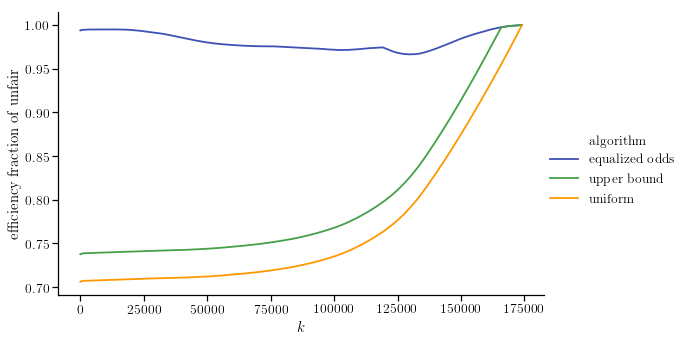

In [10]:
df_pop = pd.DataFrame(data_pop)
f = sns.relplot(data=df_pop[-(df_pop["algorithm"].isin(["no fairness"]))], x="$k$", y="efficiency fraction of unfair", hue="algorithm", kind="line", aspect=1.6)
f.savefig("efficiency_ratios.pdf")